In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import datetime
%matplotlib inline

In [229]:
data = pd.read_csv("AviationData.txt", delimiter="|")
data.describe()

,Event Id,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,...,Air Carrier,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase of Flight,Report Status,Publication Date,
count,74428,74428,74428,74428,74428,74428,74428,74428,74428,74428,...,74428,74428,74428,74428,74428,74428,74428,74428,74428,74428
unique,73349,2,74428,11561,23841,171,14701,15586,9200,21565,...,2726,115,41,62,359,4,13,4,3139,1
top,20001212X19172,Accident,ERA14FA068,06/30/1984,"ANCHORAGE, AK",United States,,,,,...,,0,0,0,1,VMC,LANDING,Probable Cause,,
freq,3,71584,1,25,372,70757,53144,53153,32705,29806,...,70752,40380,42975,40358,21333,66572,17747,69938,12840,74428


In [230]:
def print_row_col(data):

    n_rows = data.shape[0]
    n_cols = data.shape[1]
    print(f"There are {n_rows} rows in the airplane crash dataset")
    print(f"There are {n_cols} columns in the airplane crash dataset")

In [231]:
def clean_data(data):

    # Drop columns that seem to have significant missing data or are not relevant
    data.drop(columns=['Event Id ', ' Registration Number ', ' Make ', ' Model ', ' Amateur Built ', ' FAR Description ', ' Schedule ', ' Air Carrier ', ' Broad Phase of Flight ', ' Report Status ', ' Publication Date '], inplace=True)
    data = data.iloc[:, :-1]
    # Replace missing data in columns with NaN
    data.replace(r'^\s*$', np.NaN, regex=True, inplace=True)
    # Remove extra whitespace in columns 
    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x).rename(columns=lambda x: x.strip())
    # Decided to drop these columns
    # data.drop(columns=['Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured'], inplace=True) # Columns that appear to be primarily empty
    # Fill NaN values with zero
    data.fillna(value={'Total Fatal Injuries': 0, 'Aircraft Category': 'Airplane'}, inplace=True)
    # Convert to int
    data['Total Fatal Injuries'] = data['Total Fatal Injuries'].astype(int)
    data['is_fatal'] = data['Total Fatal Injuries'].map(lambda x: 1 if x > 0 else 0)

    data.fillna(value={'Total Serious Injuries': 0, 'Total Minor Injuries': 0, 'Total Uninjured': 0}, inplace=True)

    data['Event Date'] = pd.to_datetime(data['Event Date'])
    data['Month'] = data['Event Date'].dt.month
    data['Day'] = data['Event Date'].dt.day
    data['Year'] = data['Event Date'].dt.year
    # Drop columns that are not useful
    # data.drop(columns=['Total Serious Injuries', 'Total Minor Injuries', 'Total Uninjured'], inplace=True)
    


    return data




In [232]:
# Look at data before proprocessing
print(data.describe())
print(data.head(1))
print_row_col(data)


              Event Id   Investigation Type   Accident Number    Event Date   \
count             74428                74428             74428         74428   
unique            73349                    2             74428         11561   
top     20001212X19172             Accident        ERA14FA068    06/30/1984    
freq                  3                71584                 1            25   

              Location          Country   Latitude   Longitude   \
count             74428            74428      74428       74428   
unique            23841              171      14701       15586   
top      ANCHORAGE, AK    United States                           
freq                372            70757      53144       53153   

        Airport Code   Airport Name   ...  Air Carrier   \
count           74428          74428  ...         74428   
unique           9200          21565  ...          2726   
top                                   ...                 
freq            32705      

In [233]:
# Preprocess data
data = clean_data(data)

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [234]:
# Look at data after proprocessing
print(data.describe())
print(data.head(1))
print_row_col(data)


       Total Fatal Injuries      is_fatal         Month           Day  \
count          74428.000000  74428.000000  74426.000000  74426.000000   
mean               0.563189      0.198608      6.577728     15.720313   
std                5.063542      0.398955      3.061183      8.833594   
min                0.000000      0.000000      1.000000      1.000000   
25%                0.000000      0.000000      4.000000      8.000000   
50%                0.000000      0.000000      7.000000     16.000000   
75%                0.000000      0.000000      9.000000     23.000000   
max              349.000000      1.000000     12.000000     31.000000   

               Year  
count  74426.000000  
mean    1995.570782  
std        9.286103  
min     1948.000000  
25%     1987.000000  
50%     1995.000000  
75%     2003.000000  
max     2013.000000  
  Investigation Type Accident Number Event Date          Location  \
0           Accident      ERA14FA068 2013-12-08  Jacksonville, FL   

     

In [235]:
# Look at NaNs
print(data.isna().sum())
print(data.isna().mean()*100) # Percent of NaNs in data for each column


Investigation Type            0
Accident Number               0
Event Date                    2
Location                     89
Country                     511
Latitude                  53144
Longitude                 53153
Airport Code              32705
Airport Name              29806
Injury Severity              56
Aircraft Damage            2161
Aircraft Category             0
Number of Engines          3230
Engine Type                2721
Purpose of Flight          3010
Total Fatal Injuries          0
Total Serious Injuries        0
Total Minor Injuries          0
Total Uninjured               0
Weather Condition          1516
is_fatal                      0
Month                         2
Day                           2
Year                          2
dtype: int64
Investigation Type         0.000000
Accident Number            0.000000
Event Date                 0.002687
Location                   0.119579
Country                    0.686570
Latitude                  71.403235
Lon

7509

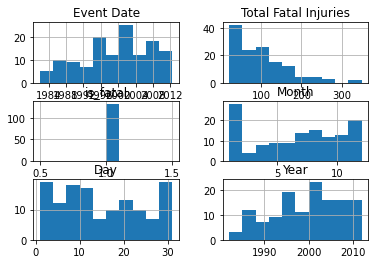

In [236]:
# Looking at histogram of fatal injuries above 100
data[data['Total Fatal Injuries'] > 20].hist() # looking at only plane crashes with greater than 100 fatalities
len(data[data['Total Fatal Injuries'] > 1]) # Dropped down to 54 plane crashes

In [237]:
# Make new dataframe filtered by > 25 Total Fatal Injuries
data_sig_fatal = data[data['Total Fatal Injuries'] > 25] # Drop to only crashes including more than 25 fatalities

In [238]:
data.loc[data['Event Date']=='09/11/2001'] # Looking at 9/11 attacks 
data.loc[data['Event Date']=='09/11/2001']['Total Fatal Injuries'] # Looking at 9/11 attacks


22942    44
22943    64
22944    65
22945    92
Name: Total Fatal Injuries, dtype: int64

In [239]:
data['Country'].value_counts()
# Interesting to see most of the large plane crashes are in the US folowed by Colombia, Peru, Nigeria
print(data.head(1))

  Investigation Type Accident Number Event Date          Location  \
0           Accident      ERA14FA068 2013-12-08  Jacksonville, FL   

         Country   Latitude   Longitude Airport Code  \
0  United States  30.319723  -81.514167          CRG   

                     Airport Name Injury Severity  ... Purpose of Flight  \
0  Jacksonville Executive Airport        Fatal(3)  ...          Personal   

  Total Fatal Injuries Total Serious Injuries Total Minor Injuries  \
0                    3                      0                    0   

  Total Uninjured  Weather Condition is_fatal Month  Day    Year  
0               0                IMC        1  12.0  8.0  2013.0  

[1 rows x 24 columns]


In [240]:
# Check fatality rate for plane crashes?
# Is Fatal?
# Are flights overall becoming more safe?
# Are large planes safer than small planes?
# Is it dangerous to fly in bad weather?

<!-- Narrow to United states
Lat/Long only 30% of data
Plot by state maybe
Fatality rate {by_state, by_plane_type, by_year, by_weather}
Build classifier based off US to predict fatalities -->

In [241]:
# Add column is_fatal
US_accidents = data[data['Country'] == 'United States']
US_accidents

,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,Injury Severity,...,Purpose of Flight,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,is_fatal,Month,Day,Year
0,Accident,ERA14FA068,2013-12-08,"Jacksonville, FL",United States,30.319723,-81.514167,CRG,Jacksonville Executive Airport,Fatal(3),...,Personal,3,0,0,0,IMC,1,12.0,8.0,2013.0
1,Accident,ERA14FA066,2013-12-06,"Sebring, FL",United States,27.463333,-81.366667,SEF,Sebring Regional Airport,Fatal(1),...,Positioning,1,0,0,0,NaN,1,12.0,6.0,2013.0
2,Accident,ANC14CA010,2013-12-04,"Soldotna, AK",United States,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,NaN,0,12.0,4.0,2013.0
3,Accident,ERA14CA062,2013-12-03,"Hendersonville, NC",United States,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,NaN,0,12.0,3.0,2013.0
4,Accident,ERA14LA059,2013-12-02,"Trenton, SC",United States,33.736944,-81.818611,6J6,Edgefield County Airport,Non-Fatal,...,Personal,0,0,1,0,NaN,0,12.0,2.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74422,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),...,Personal,2,0,0,0,IMC,1,6.0,19.0,1977.0
74423,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,Fatal(3),...,Personal,3,0,0,0,IMC,1,8.0,30.0,1974.0
74424,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),...,Personal,4,0,0,0,UNK,1,7.0,19.0,1962.0
74425,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),...,Personal,2,0,0,0,UNK,1,10.0,24.0,1948.0


 CA              7811
 FL              4938
 AK              4912
 TX              4910
 AZ              2410
                 ... 
Kauai               1
 San Juan Is.       1
 Maui               1
 MP                 1
 FT. MYER           1
Name: Location_State, Length: 79, dtype: int64


/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


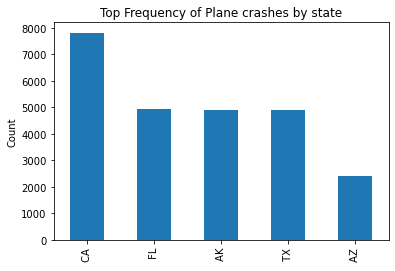

In [242]:
# Location (Stolen from Ryan's notebook)
US_accidents[['Location_City','Location_State']] = US_accidents['Location'].str.split(',',expand=True)[[0,1]]
US_accidents[['Location','Location_City','Location_State']].head()

US_accidents.groupby(['Location_State']).count()

freq_by_state = US_accidents['Location_State'].value_counts()
print(freq_by_state)
freq_by_state[:5].plot(kind='bar', title='Top Frequency of Plane crashes by state', ylabel='Count')



In [243]:
def plot_frequency_by_state(data, title, ylabel):
    freq_by_state = data['Location_State'].value_counts()
    print(freq_by_state)
    freq_by_state[:5].plot(kind='bar', title=title, ylabel=ylabel)


In [244]:
def plot_frequency_by_country(data, title, ylabel):
    freq_by_country = data['Country'].value_counts()
    print(freq_by_country)
    freq_by_country[:5].plot(kind='bar', title=title, ylabel=ylabel)

 CA              7811
 FL              4938
 AK              4912
 TX              4910
 AZ              2410
                 ... 
Kauai               1
 San Juan Is.       1
 Maui               1
 MP                 1
 FT. MYER           1
Name: Location_State, Length: 79, dtype: int64


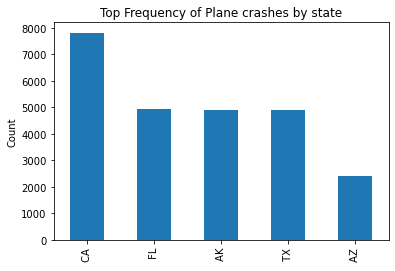

In [245]:
plot_frequency_by_state(US_accidents, 'Top Frequency of Plane crashes by state', 'Count')
# Looking at the top 5 states with the most plane crashes
# CA is the most common state with the most plane crashes
# Followed by TX, FL, and NY

United States    70757
Canada             204
Mexico             188
Bahamas            182
Australia          158
                 ...  
Eritrea              1
Ivory Coast          1
Niger                1
Madagascar           1
Bermuda              1
Name: Country, Length: 170, dtype: int64


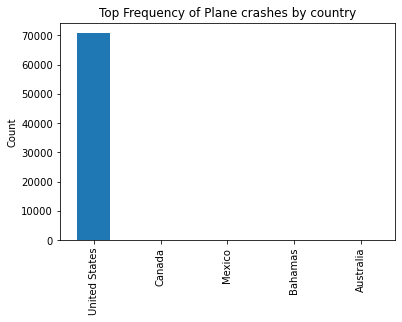

In [246]:
plot_frequency_by_country(data, 'Top Frequency of Plane crashes by country', 'Count')


# Looking at the top 5 countries with the most plane crashes
# US is the most common country with the most plane crashes
# Followed by China, India, and Russia

## Logistic Regression to Predict if plane crash is fatal or not


In [247]:
print(US_accidents.columns)
print(US_accidents.dtypes)
print(US_accidents.head())

Index(['Investigation Type', 'Accident Number', 'Event Date', 'Location',
       'Country', 'Latitude', 'Longitude', 'Airport Code', 'Airport Name',
       'Injury Severity', 'Aircraft Damage', 'Aircraft Category',
       'Number of Engines', 'Engine Type', 'Purpose of Flight',
       'Total Fatal Injuries', 'Total Serious Injuries',
       'Total Minor Injuries', 'Total Uninjured', 'Weather Condition',
       'is_fatal', 'Month', 'Day', 'Year', 'Location_City', 'Location_State'],
      dtype='object')
Investigation Type                object
Accident Number                   object
Event Date                datetime64[ns]
Location                          object
Country                           object
Latitude                          object
Longitude                         object
Airport Code                      object
Airport Name                      object
Injury Severity                   object
Aircraft Damage                   object
Aircraft Category                 object


In [248]:
# Filling NaNs with most frequent
US_accidents['Weather Condtion'] = US_accidents['Weather Condition'].fillna(US_accidents.mode().iloc[0])
US_accidents

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Investigation Type,Accident Number,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,Injury Severity,...,Total Minor Injuries,Total Uninjured,Weather Condition,is_fatal,Month,Day,Year,Location_City,Location_State,Weather Condtion
0,Accident,ERA14FA068,2013-12-08,"Jacksonville, FL",United States,30.319723,-81.514167,CRG,Jacksonville Executive Airport,Fatal(3),...,0,0,IMC,1,12.0,8.0,2013.0,Jacksonville,FL,IMC
1,Accident,ERA14FA066,2013-12-06,"Sebring, FL",United States,27.463333,-81.366667,SEF,Sebring Regional Airport,Fatal(1),...,0,0,NaN,1,12.0,6.0,2013.0,Sebring,FL,NaN
2,Accident,ANC14CA010,2013-12-04,"Soldotna, AK",United States,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,0,12.0,4.0,2013.0,Soldotna,AK,NaN
3,Accident,ERA14CA062,2013-12-03,"Hendersonville, NC",United States,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,0,12.0,3.0,2013.0,Hendersonville,NC,NaN
4,Accident,ERA14LA059,2013-12-02,"Trenton, SC",United States,33.736944,-81.818611,6J6,Edgefield County Airport,Non-Fatal,...,1,0,NaN,0,12.0,2.0,2013.0,Trenton,SC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74422,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),...,0,0,IMC,1,6.0,19.0,1977.0,EUREKA,CA,IMC
74423,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,Fatal(3),...,0,0,IMC,1,8.0,30.0,1974.0,Saltville,VA,IMC
74424,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),...,0,0,UNK,1,7.0,19.0,1962.0,BRIDGEPORT,CA,UNK
74425,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),...,0,0,UNK,1,10.0,24.0,1948.0,MOOSE CREEK,ID,UNK


In [249]:

#Fill Nan's with most frequent damage value of 'Substantial'
US_accidents['Aircraft Damage'].value_counts()
US_accidents['Aircraft Damage'].fillna('Substantial', inplace=True) # Assume NaNs are VMC conditions
# Map strings to ints
US_accidents['Aircraft Damage'] = US_accidents['Aircraft Damage'].map({'Substantial': 1, 'Destroyed': 2, 'Minor': 0})
US_accidents['Aircraft Damage'].unique()

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([1, 2, 0])

In [250]:
US_accidents['Number of Engines'].value_counts()
US_accidents['Number of Engines'].fillna(1, inplace=True)
US_accidents['Number of Engines'] = US_accidents['Number of Engines'].astype(int)
US_accidents['Number of Engines'].unique()

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([2, 1, 4, 0, 3])

In [251]:
## Convert NaNs to most frequent value


US_accidents['Weather Condition'].value_counts()
US_accidents['Weather Condition'].fillna('VMC', inplace=True) # Assume NaNs are VMC conditions
US_accidents['Weather Condition'].isna().sum()
US_accidents['Weather Condition'] = US_accidents['Weather Condition'].map({'IMC': 0, 'VMC': 1, 'UNK': 2})
US_accidents['Weather Condition'].unique()

/Users/adam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


array([0, 1, 2])

In [252]:
# x = US_accidents[['Aircraft Damage', 'Aircraft Category', 'Number of Engines', 'Purpose of Flight', 'Weather Condition']]
x = US_accidents[['Aircraft Damage', 'Number of Engines', 'Weather Condition']]
y = US_accidents['is_fatal']

In [253]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [254]:
x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=0)

model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [255]:
model.classes_
model.predict_proba(x_test)
y_pred = model.predict(x_test)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.874940376291847
0.8719615602035048


In [256]:
confusion_matrix(y_test, y_pred)

array([[10420,  1072],
       [  740,  1920]])

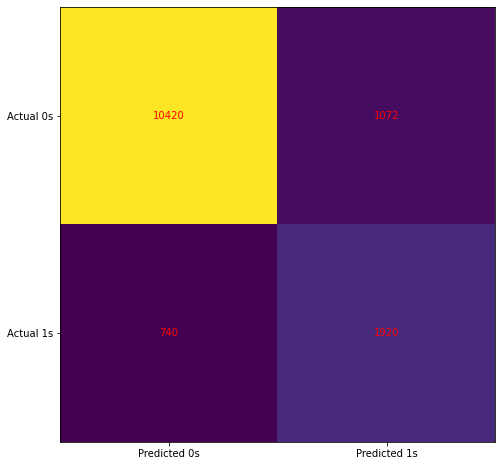

In [257]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()




In [258]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """ This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`. """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    

In [259]:
def plot_auc(model, x_test):
    y_pred = model.predict_proba(x_test)
    y_pred = y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    print(f"The AUC score is {auc}")

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     11492
           1       0.64      0.72      0.68      2660

    accuracy                           0.87     14152
   macro avg       0.79      0.81      0.80     14152
weighted avg       0.88      0.87      0.87     14152

[[10420  1072]
 [  740  1920]]
0.09328228332753219
0.7218045112781954


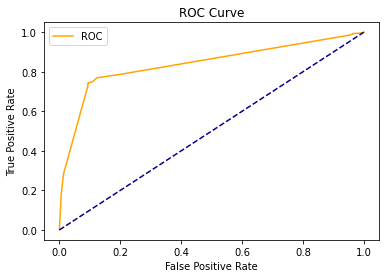

The AUC score is 0.8389496354443366
Normalized confusion matrix


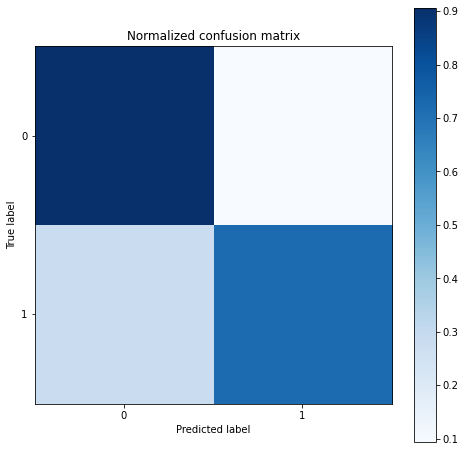

In [260]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
fpr = cm[0][1] / (cm[0][1] + cm[0][0])
print(fpr)
tpr = cm[1][1] / (cm[1][1] + cm[1][0])
print(tpr)
plot_auc(model, x_test)
# plot_roc_curve(fpr, tpr)
plot_confusion_matrix(cm, classes=['0', '1'], normalize=True, title='Normalized confusion matrix')


In [261]:
print(classification_report(y, model.predict(x)))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     57668
           1       0.64      0.73      0.68     13089

    accuracy                           0.87     70757
   macro avg       0.79      0.82      0.80     70757
weighted avg       0.88      0.87      0.88     70757



In [262]:
print(model.intercept_)
print(model.coef_)
print(model.predict_proba(x_test))
print(model.predict(x_test))
print(model.score(x_test, y_test))
print(model.score(x_train, y_train))


[-4.9793177]
[[ 3.17868145  0.14617615 -1.1302386 ]]
[[0.40275891 0.59724109]
 [0.94184335 0.05815665]
 [0.94184335 0.05815665]
 ...
 [0.94184335 0.05815665]
 [0.36815062 0.63184938]
 [0.99602937 0.00397063]]
[1 0 0 ... 0 1 0]
0.8719615602035048
0.874940376291847


In [263]:
def LogisticRegression_model(x, y, C=1.0, penalty='l1', max_iter=1000, tol=1e-6):
    
    # Create Logistic Regression Model
    model = LogisticRegression(solver='liblinear', random_state=0, C=C, penalty=penalty, max_iter=max_iter, tol=tol)
    # get the training and testing data
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    # fit the model
    model.fit(x_train,y_train)
    return (model, x_train, x_test, y_train, y_test)

In [264]:
model, x_train, x_test, y_train, y_test = LogisticRegression_model(x, y)

y_pred = model.predict(x_test)
print(model.score(x_test, y_test))

0.874335782928208


In [265]:
# Logistic Regression with GridSearchCV
clf = GridSearchCV(LogisticRegression(solver='liblinear', random_state=0),
                   param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'],
                                'max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                                'tol': [1e-6, 1e-3]},
                   cv=5)
clf.fit(x_train, y_train)


print(f"The best parameters for the model are {clf.best_params_}")
print(clf.best_score_)
print(clf.score(x_test, y_test))


The best parameters for the model are {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'tol': 1e-06}
0.8743475418500347
0.874335782928208


In [266]:
parameters = clf.best_params_
(model, x_train, x_test, y_train, y_test) = LogisticRegression_model(x, y, **parameters)
print(f"The model score for testing dataset is {model.score(x_test, y_test)}")
print(f"The model score for training dataset is {model.score(x_train, y_train)}")
print(f"The model coeffiecents are {model.coef_}")
print(f"The model intercept is {model.intercept_}")

print(model.predict_proba(x_test))


The model score for testing dataset is 0.8733747880158281
The model score for training dataset is 0.874667872689242
The model coeffiecents are [[ 2.99695603  0.         -1.09585993]]
The model intercept is [-4.53946962]
[[0.41130274 0.58869726]
 [0.93329077 0.06670923]
 [0.9964432  0.0035568 ]
 ...
 [0.93329077 0.06670923]
 [0.93329077 0.06670923]
 [0.93329077 0.06670923]]


              precision    recall  f1-score   support

           0       0.94      0.91      0.92     14455
           1       0.63      0.73      0.68      3235

    accuracy                           0.87     17690
   macro avg       0.79      0.82      0.80     17690
weighted avg       0.88      0.87      0.88     17690

[[13100  1355]
 [  885  2350]]
0.09373919059149083
0.7264296754250387


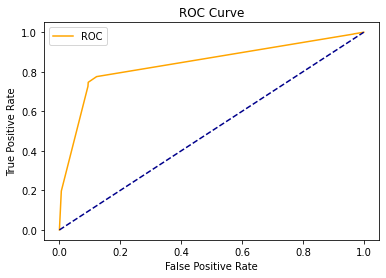

The AUC score is 0.8417285644250103
Normalized confusion matrix


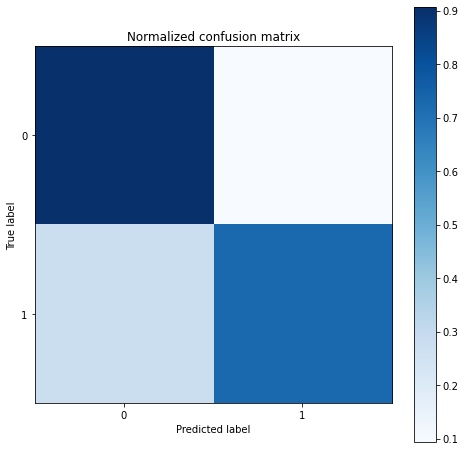

In [267]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
fpr = cm[0][1] / (cm[0][1] + cm[0][0])
print(fpr)
tpr = cm[1][1] / (cm[1][1] + cm[1][0])
print(tpr)
plot_auc(model, x_test)
plot_confusion_matrix(cm, classes=['0', '1'], normalize=True, title='Normalized confusion matrix')


In [268]:
def plot_probability_distribution(model, x_test):
    y_pred = model.predict_proba(x_test)
    y_pred = y_pred[:, 1]
    plt.hist(y_pred, bins=20, range=(0, 1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Probability Distribution')
    plt.show()
    


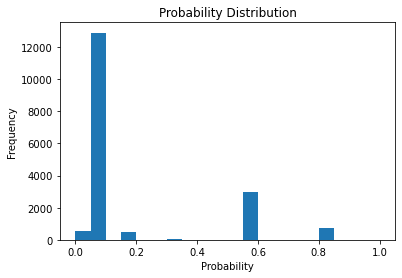

In [269]:
plot_probability_distribution(model, x_test)

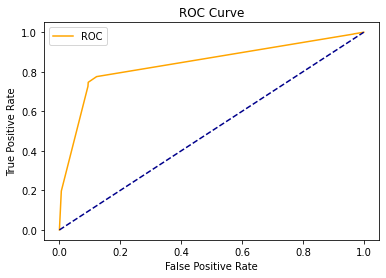

The AUC score is 0.8417285644250103


In [270]:
plot_auc(model, x_test)

